In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)



Using Pytorch version :  1.10.0  Device :  cuda


오디오들이 
1초, 2초, 3초 각각 다르다.

음성이 뭉개진 데이터도 있다.

# 추출해야하는 feature

- time-frequency : 13 MFCC  
- pitch, rolloff, ZCR, energy entropy, spectral flux,  spectral centroid, energy

### 오디오 전처리

https://hyunlee103.tistory.com/36

https://hyongdoc.tistory.com/404

https://ichi.pro/ko/python-eul-sayonghan-eum-ag-jangleu-bunlyu-218892206272728

https://lucaseo.github.io/posts/2021-01-22-hands-on-preprocess-audio-data/ : librosa 설명

torchaudio

https://ahnjg.tistory.com/93

https://medium.com/analytics-vidhya/how-to-classify-sounds-using-pytorch-27c9f2d4d714 :mfcc

https://www.youtube.com/watch?v=rlypsap6Wow&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=8

https://www.youtube.com/watch?v=oltGIc4uo5c&t=5132s 피처들


torchaudio를 사용해 음성을 읽으면 음성 데이터와 sampling rate를 반환.

sampling rate : 1초당 들리는 sample의 개수 (1초를 더 쪼갠것)

데이터 길이 / sampling rate = 음성 파일의 시간

In [7]:
!pip install torchaudio

------

In [8]:
!pip install librosa --user

In [12]:
!pip install numba==0.53# numpy 버전 맞추기 위해서

  Using cached numba-0.53.0-cp38-cp38-win_amd64.whl (2.3 MB)
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'D:\\miniconda3\\envs\\local_torch\\Lib\\site-packages\\~umba\\core\\runtime\\_nrt_python.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
import numpy as np
np.__version__

'1.20.3'

In [12]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt

FIG_SIZE = (15,10)

#audio_path = './voice_data/disorder/export/blues.00000.wav'
#audio_path = './voice_data/disorder/export/105-phrase.wav'
audio_path = './voice_data/disorder/export/101-phrase.wav'
sig, sr = librosa.load(audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
#모음데이터는 1초에서 3초로 sampling 했다고 한다. (2초)

print(sig.shape,sr)
print(sig.shape[0]/sr)
sr_time=sig.shape[0]/sr
#155269 sample임을 알 수 있고
#sampling frame이 50000이다.
#시간 : 155269/50000

#음성 파일마다 sample수가 달라서, cnn은 통일해야한다.
#통일안하면, mfcc frame수도 달라진다.

(155269,) 50000
3.10538


In [22]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt

FIG_SIZE = (15,10)

#audio_path = './voice_data/disorder/export/blues.00000.wav'
#audio_path = './voice_data/disorder/export/105-phrase.wav'
audio_path = './voice_data/healthy/export/3-phrase.wav'
sig_healthy, sr_sig_healthy = librosa.load(audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
#모음데이터는 1초에서 3초로 sampling 했다고 한다. (2초)

print(sig.shape,sr)
print(sig.shape[0]/sr)
sr_time_sig_healthy=sig.shape[0]/sr
print(sr_time_sig_healthy)
#155269 sample임을 알 수 있고
#sampling frame이 50000이다.
#시간 : 155269/50000

#음성 파일마다 sample수가 달라서, cnn은 통일해야한다.
#통일안하면, mfcc frame수도 달라진다.

(155269,) 50000
3.10538
3.10538


Text(0.5, 1.0, 'Waveform')

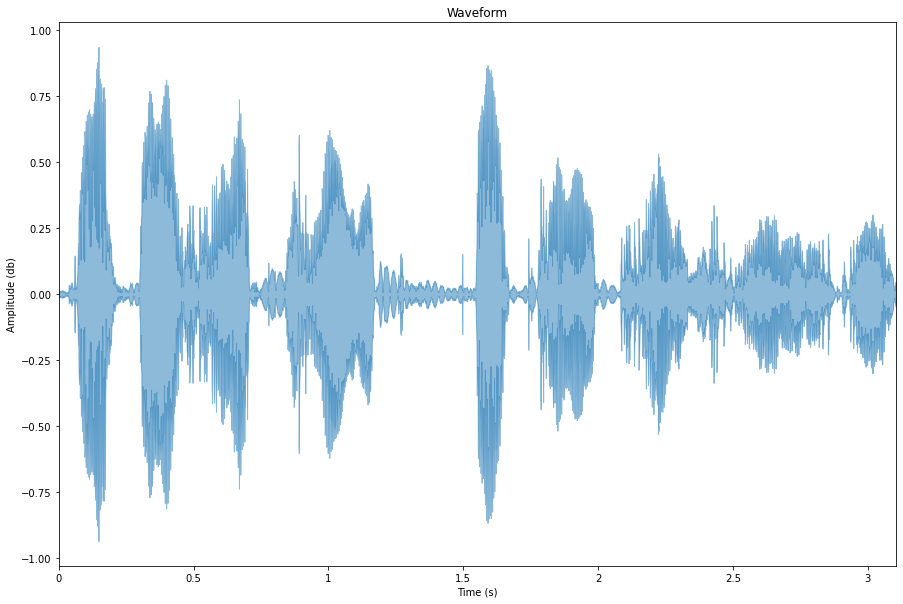

In [4]:
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(sig, sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (db)")
plt.title("Waveform")

## 단순 푸리에 변환 → Spectrum

Text(0.5, 1.0, 'Power spectrum')

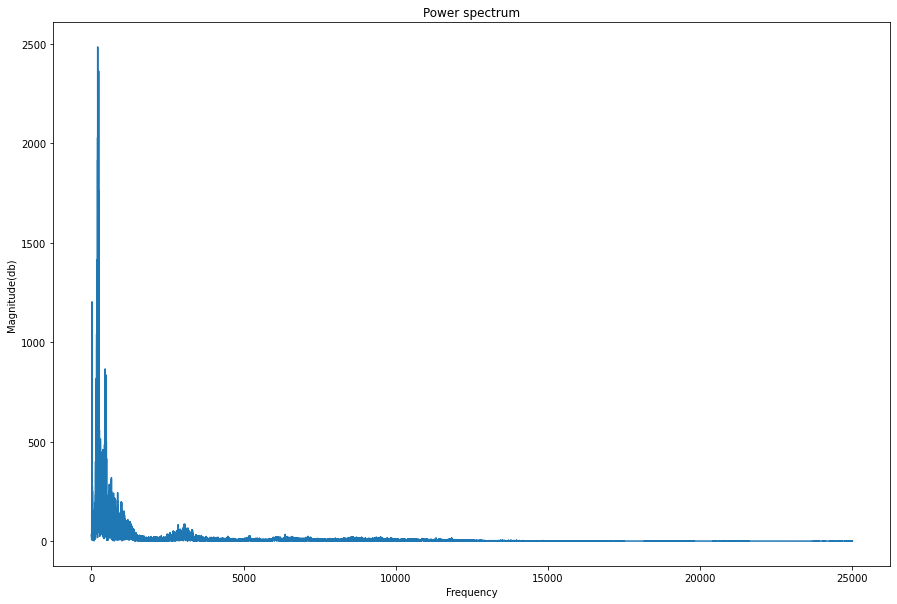

In [5]:
fft = np.fft.fft(sig)

# 복소공간 값 절댓갑 취해서, magnitude 구하기
magnitude = np.abs(fft) 

# Frequency 값 만들기
f = np.linspace(0,sr,len(magnitude))

# 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날려고 앞쪽 절반만 사용한다.
#left_spectrum = magnitude
#left_f=f
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude(db)")
plt.title("Power spectrum")

In [6]:
sig.shape[0]

155269

In [7]:
np.int64(np.ceil(1250/4))

313

# STFT

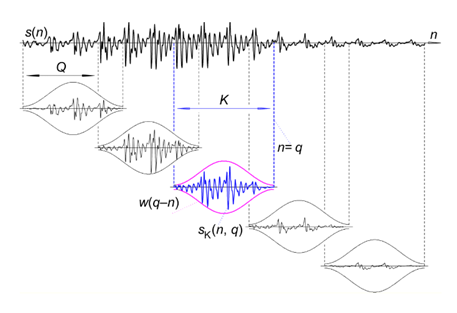

- https://sanghyu.tistory.com/38?category=1120070

In [27]:
stfts=librosa.stft(sig,win_length=win_length,n_fft=n_fft, hop_length=hop_length)
print(len(stfts[0]))

497


# MFCC

- window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
- 자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
- 초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
- nfft : WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
- hop_length : 얼마만큼 시간 주기를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4 또는 10ms만큼으로 한다고 한다. hop_length가 mfcc의 frame수를 결정한다.


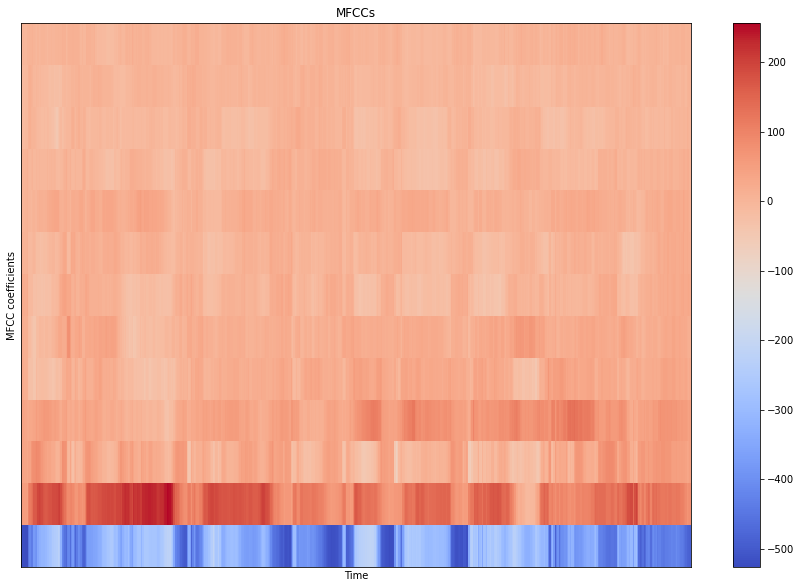

(13, 497)


In [8]:
# MFCCs
#librosa에서는 stft로 수행해서, 시간 정보를 보존하기 위해 frame단위로 fft 수행.
# extract 13 MFCCs

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.

win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다. (stride)
#hop: 윈도우가 겹치는 사이즈

#hop_length가 mfcc의 frame수를 결정한다.


MFCCs = librosa.feature.mfcc(sig, sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()
print(MFCCs.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

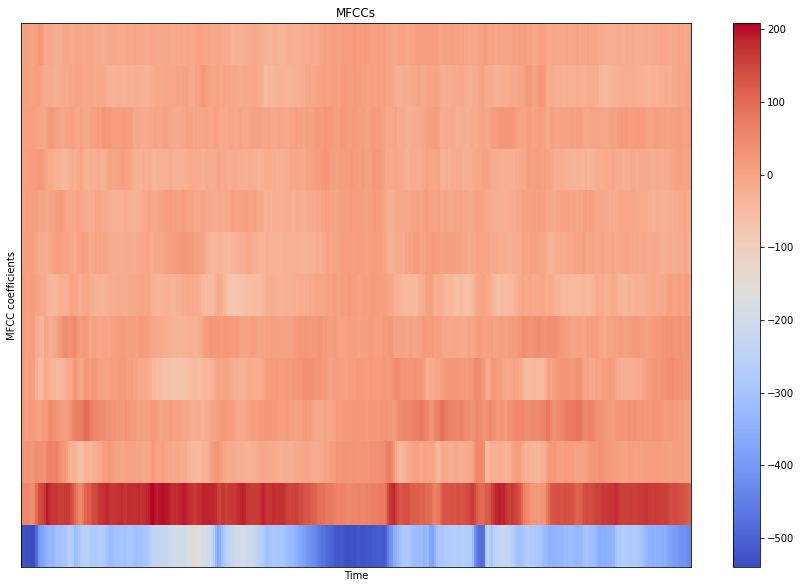

(13, 328)


In [30]:
# MFCCs
#librosa에서는 stft로 수행해서, 시간 정보를 보존하기 위해 frame단위로 fft 수행.
# extract 13 MFCCs

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.

win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다. (stride)
#hop: 윈도우가 겹치는 사이즈

#hop_length가 mfcc의 frame수를 결정한다.


MFCCs = librosa.feature.mfcc(sig_healthy, sr_sig_healthy,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()
print(MFCCs.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

# STFT

### MFCC 497 frame을 시간으로 다시 변환

 round( sample수 / hop_length )= 497 frame
 
 497frame * hop_length = sample 수


In [35]:
np.ceil(155269/313)

497.0

In [40]:
497*313

155561

497 frame (50,000 sr) ->  3.1초


MFCC 500 frame을 기준으로 길이 고정.

In [41]:
500*313

156500

In [16]:
np.ceil(156200/313)

500.0

## 시간을 기준으로 자르기

sample_rate * 시간


In [7]:
50000 * 2.5

125000.0

In [6]:
np.ceil(125000/313)

400.0

# 제로 크로싱

In [4]:
zero_crossing = librosa.zero_crossings()

TypeError: zero_crossings() missing 1 required positional argument: 'y'

# 스펙트로그램

Text(0.5, 1.0, 'Spectrogram (dB)')

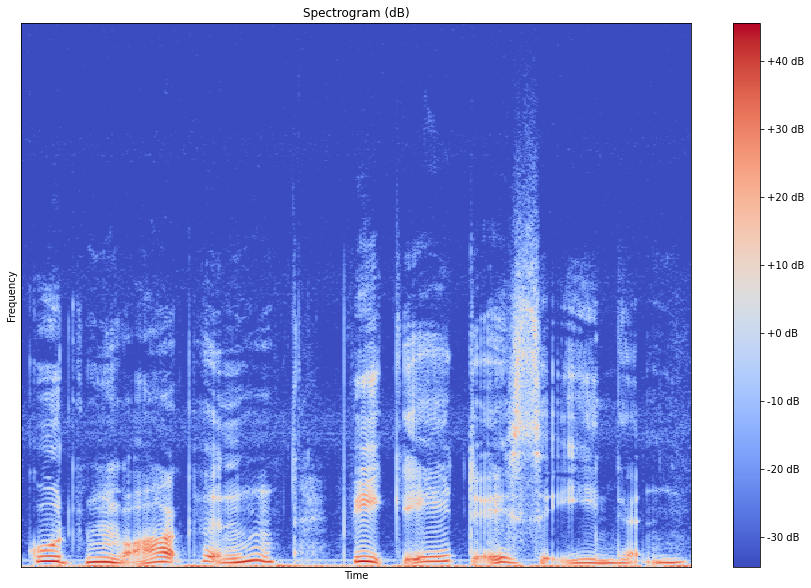

In [18]:
stfts=librosa.stft(sig,win_length=win_length,n_fft=n_fft, hop_length=hop_length)
plt.figure(figsize=FIG_SIZE)
magnitude = np.abs(stfts)
log_spectrogram = librosa.amplitude_to_db(magnitude)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

Text(0.5, 1.0, 'Spectrogram (dB)')

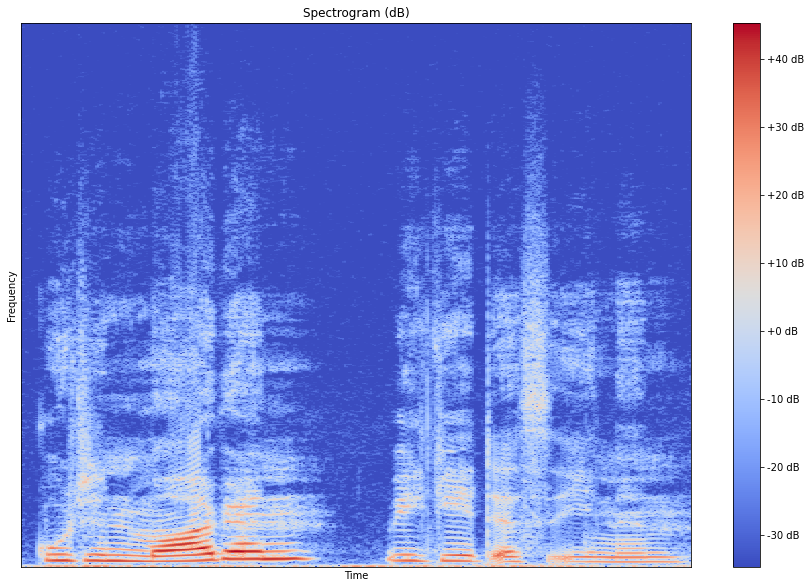

In [24]:
#healthy
stfts=librosa.stft(sig_healthy,win_length=win_length,n_fft=n_fft, hop_length=hop_length)
plt.figure(figsize=FIG_SIZE)
magnitude = np.abs(stfts)
log_spectrogram = librosa.amplitude_to_db(magnitude)
librosa.display.specshow(log_spectrogram, sr=sr_sig_healthy, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

# 멜 스펙트로그램

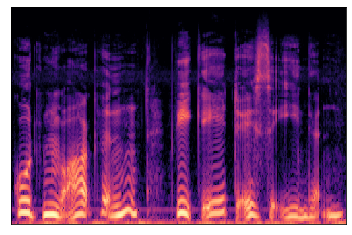

In [28]:
mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
librosa.display.specshow(mel_feature, sr=sr, hop_length=hop_length)

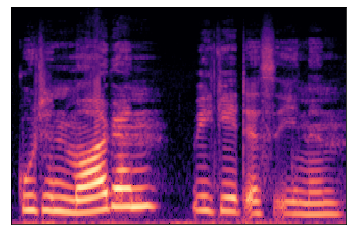

In [29]:
mel_feature = librosa.feature.melspectrogram(sig_healthy,sr=sr_sig_healthy,hop_length=hop_length,n_fft=n_fft)
mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
librosa.display.specshow(mel_feature, sr=sr, hop_length=hop_length)